# Nonlinear Convection Equation

The **1D nonlinear convection equation** describes how waves steepen as they propagate (like ocean waves approaching shore):

$$\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = 0$$

**Where:**

* $u(t, x)$ = velocity at position $x$ and time $t$
* $u \frac{\partial u}{\partial x}$ = nonlinear convection term (causes wave steepening)

**Physical meaning:** Tall parts of the wave travel faster than short parts, causing the wave to steepen over time.

In [30]:
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import random, grad, jit, vmap
import optax

import jax.numpy as jnp

import copy

# Problem parameters

L = 3.0  # length of domain
T = 2.0  # final time

# 1. Initial Condition points (10 points at t=0)
# t_ic = jnp.zeros((10, 1))
# x_ic = jnp.linspace(0, 1, 10).reshape(-1, 1)
# u_ic = jnp.sin(jnp.pi * x_ic)


# Initial condition: wave packet in first 1/3
x_ic = jnp.linspace(0, L, 50).reshape(-1, 1)  # Sample whole domain
t_ic = jnp.zeros((50, 1))

# u = sin(πx) for x ≤ 1, otherwise u = 0
u_ic = jnp.where(x_ic <= 1.0, 
                 jnp.sin(jnp.pi * x_ic), 
                 0.0)

# 2. Boundary Condition points (20 total: 10 at each edge)

"""
# Using Dirichlet boundaries: u(0, t) = 0, u(L, t) = 0 - fixed values at edges

# Left boundary (x=0):
t_bc_left = jnp.linspace(0, 1, 10).reshape(-1, 1)
x_bc_left = jnp.zeros((10, 1))

# Right boundary (x=1):
t_bc_right = jnp.linspace(0, 1, 10).reshape(-1, 1)
x_bc_right = jnp.ones((10, 1))

# Combine them:
t_bc = jnp.concatenate([t_bc_left, t_bc_right])
x_bc = jnp.concatenate([x_bc_left, x_bc_right])
u_bc = jnp.zeros((20, 1))
"""
# Using periodic boundaries

# Left boundary (x=0):
t_bc_left = jnp.linspace(0, T, 10).reshape(-1, 1)
x_bc_left = jnp.zeros((10, 1))

# Right boundary (x=1):
t_bc_right = jnp.linspace(0, T, 10).reshape(-1, 1)
x_bc_right = L * jnp.ones((10, 1))


# 3. Physics collocation points (30×30 = 900 points)
t_vals = jnp.linspace(0, T, 30)
x_vals = jnp.linspace(0, L, 30)
T_grid, X_grid = jnp.meshgrid(t_vals, x_vals)
t_physics = T_grid.reshape(-1, 1)
x_physics = X_grid.reshape(-1, 1)



# Neural Network

def init_network_params(layer_sizes, key):
    """
    Initialize parameters for a fully connected network.
    
    Args:
        layer_sizes: List of layer sizes, e.g., [2, 32, 32, 32, 1]
                    (input_dim, hidden1, hidden2, hidden3, output_dim)
        key: JAX random key for initialization
        
    Returns:
        params: List of dictionaries, each containing 'w' and 'b'
    """
    # Split random key for each layer
    keys = random.split(key, len(layer_sizes))
    
    params = []
    for i in range(len(layer_sizes) - 1):
        n_in = layer_sizes[i]
        n_out = layer_sizes[i + 1]
        
        # Split key for weights and biases
        w_key, b_key = random.split(keys[i])
        
        # Xavier initialization for weights
        params.append({
            'w': random.normal(w_key, (n_in, n_out)) * jnp.sqrt(2.0 / n_in),
            'b': jnp.zeros(n_out)
        })
    
    return params


def network(params, x):
    """
    Forward pass through the network.
    
    Args:
        params: List of layer parameters (from init_network_params)
        x: Input array, shape (batch_size, input_dim)
        
    Returns:
        Output array, shape (batch_size, output_dim)
    """
    # Process all hidden layers (all but last)
    for layer in params[:-1]:
        # Linear transformation: x @ W + b
        x = jnp.dot(x, layer['w']) + layer['b']
        # Activation function
        x = jnp.tanh(x)
    
    # Output layer (no activation)
    final_layer = params[-1]
    x = jnp.dot(x, final_layer['w']) + final_layer['b']
    
    return x


# Calculate Residual

def physics_residual_single(params, t_point, x_point):

    def u(t_val, x_val):
        tx_in = jnp.array([[t_val, x_val]])
        return network(params, tx_in)[0, 0]
    
    du_dt = grad(u, argnums=0)(t_point, x_point)

    du_dx = grad(u, argnums = 1)(t_point, x_point)

    u_ = u(t_point, x_point)

    return du_dt + u_ * du_dx
    

# Vectorize to handle all physics points at once
# So vmap will call physics_residual_single 900 times, once for each (t, x) pair, keeping params fixed.
physics_residual_batch = vmap(physics_residual_single, in_axes=(None, 0, 0))


# Initialize network
key = random.PRNGKey(123)
layer_sizes = [2, 64, 64, 64, 64, 1]  # Deeper than current [2, 32, 32, 32, 1]
params = init_network_params(layer_sizes, key)

# Initialize optimizer
learning_rate = 1e-3
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)


@jit
def update_step(params, opt_state, t_ic, x_ic, u_ic, 
                t_bc_left, x_bc_left, t_bc_right, x_bc_right, t_physics, x_physics):

    def loss_fn(params):
        # 1. Initial Condition Loss
        # Network prediction at IC points
        tx_ic = jnp.concatenate([t_ic, x_ic], axis=1)  # Combine t and x
        u_pred_ic = network(params, tx_ic)
        ic_loss = jnp.mean((u_pred_ic - u_ic)**2)
        
        # 2. Boundary Condition Loss

        """
        # Dirichlet boundaries
        tx_bc = jnp.concatenate([t_bc, x_bc], axis=1)
        u_pred_bc = network(params, tx_bc)
        bc_loss = jnp.mean((u_pred_bc - u_bc)**2)
        """

        tx_bc_left = jnp.concatenate([t_bc_left, x_bc_left], axis=1)
        u_pred_bc_left = network(params, tx_bc_left)

        tx_bc_right = jnp.concatenate([t_bc_right, x_bc_right], axis=1)
        u_pred_bc_right = network(params, tx_bc_right)

        bc_loss = jnp.mean((u_pred_bc_left - u_pred_bc_right)**2)

        # 3. Physics Loss
        physics_residuals = physics_residual_batch(params, 
                                                t_physics.ravel(), # (900,) not (900, 1)
                                                x_physics.ravel() # (900,) not (900, 1)
                                                )
        physics_loss = (1e-2) * jnp.mean(physics_residuals**2) # Physics residual is of 900 points. Much more than our ic and bc points. Therefore we multiply by 1e-4 so it doesn't overpower
        
        return ic_loss + bc_loss + physics_loss
    
        # Compute loss and gradients
    loss_val, grads = jax.value_and_grad(loss_fn)(params)
    
    # Update parameters
    updates, new_opt_state = optimizer.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    
    return new_params, new_opt_state, loss_val


# Training parameters
num_iterations = 20000
save_every = 150  # Save every 150 iterations
print_every = 1000

# Storage for snapshots
snapshots = []
snapshot_iterations = []

# Prepare physics points (flatten for vmap)
t_phys_flat = t_physics.ravel()
x_phys_flat = x_physics.ravel()

# Training loop
losses = []
for i in range(num_iterations):
    params, opt_state, loss = update_step(
        params, opt_state,
        t_ic, x_ic, u_ic,
        t_bc_left, x_bc_left, t_bc_right, x_bc_right,
        t_phys_flat, x_phys_flat
        )
    
    losses.append(loss)


    # Save snapshot every 150 iterations
    if (i + 1) % save_every == 0:
        # Make a copy of params (important!)
        snapshots.append(copy.deepcopy(params))
        snapshot_iterations.append(i + 1)

    
    if (i + 1) % print_every == 0:
        print(f"Iteration {i+1}/{num_iterations}, Loss: {loss:.6f}")





Iteration 1000/20000, Loss: 0.001190
Iteration 2000/20000, Loss: 0.000537
Iteration 3000/20000, Loss: 0.000388
Iteration 4000/20000, Loss: 0.000333
Iteration 5000/20000, Loss: 0.000281
Iteration 6000/20000, Loss: 0.000248
Iteration 7000/20000, Loss: 0.000224
Iteration 8000/20000, Loss: 0.000210
Iteration 9000/20000, Loss: 0.000201
Iteration 10000/20000, Loss: 0.000195
Iteration 11000/20000, Loss: 0.000191
Iteration 12000/20000, Loss: 0.000205
Iteration 13000/20000, Loss: 0.000183
Iteration 14000/20000, Loss: 0.000293
Iteration 15000/20000, Loss: 0.000179
Iteration 16000/20000, Loss: 0.000175
Iteration 17000/20000, Loss: 0.000181
Iteration 18000/20000, Loss: 0.000174
Iteration 19000/20000, Loss: 0.000168
Iteration 20000/20000, Loss: 0.000147


# Plot Results

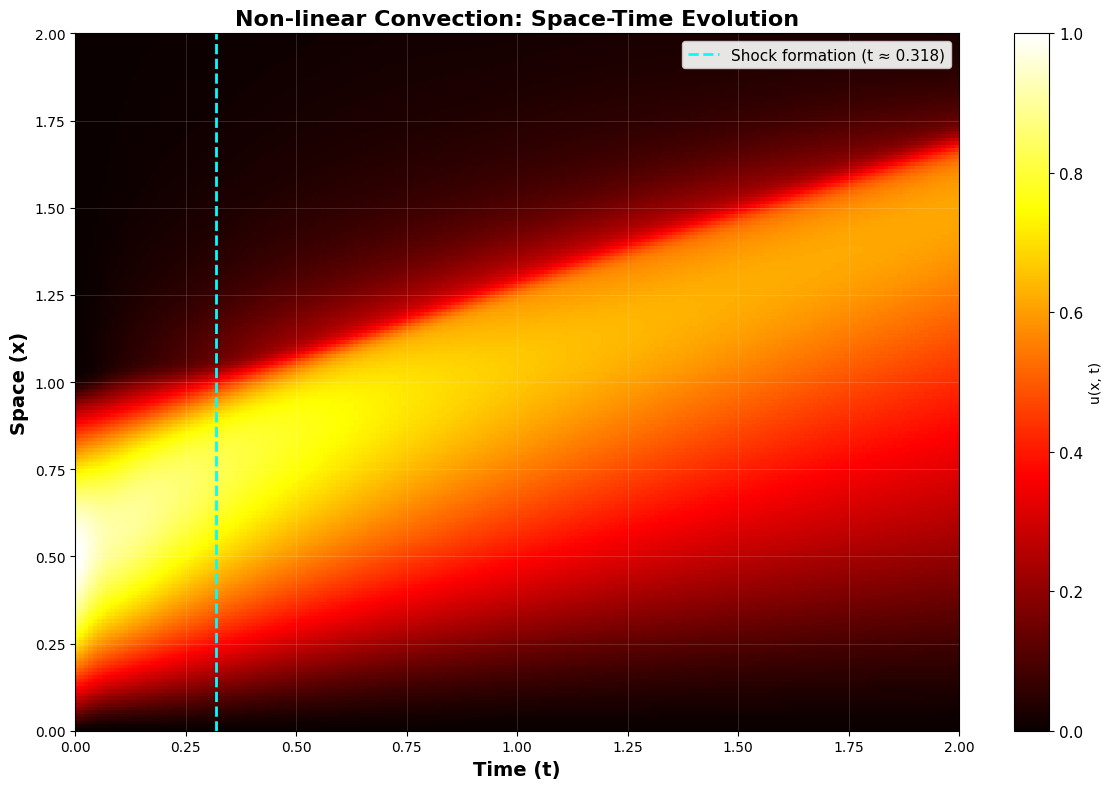

In [31]:
def plot_heatmap():
    """Create a clean heatmap of u(x,t)"""
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    # Create fine grid
    t_vals = jnp.linspace(0, 2, 200)
    x_vals = jnp.linspace(0, 2, 200)
    T_grid, X_grid = jnp.meshgrid(t_vals, x_vals)
    
    # Get predictions
    TX_flat = jnp.stack([T_grid.ravel(), X_grid.ravel()], axis=1)
    U_pred_flat = network(params, TX_flat)
    U_pred = U_pred_flat.reshape(200, 200)
    
    # Plot heatmap
    im = ax.imshow(U_pred, extent=[0, 2, 0, 2], origin='lower', 
                   aspect='auto', cmap='hot', vmin=0, vmax=1.0)
    
    # Add shock formation line
    ax.axvline(x=0.318, color='cyan', linestyle='--', linewidth=2, 
               label='Shock formation (t ≈ 0.318)')
    
    ax.set_xlabel('Time (t)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Space (x)', fontsize=14, fontweight='bold')
    ax.set_title('Non-linear Convection: Space-Time Evolution', 
                 fontsize=16, fontweight='bold')
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax, label='u(x, t)')
    cbar.ax.tick_params(labelsize=11)
    
    ax.legend(loc='upper right', fontsize=11, framealpha=0.9)
    ax.grid(True, alpha=0.2, color='white', linestyle='-', linewidth=0.5)
    
    plt.tight_layout()
    plt.savefig('convection_heatmap.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

plot_heatmap()

### Plot Wave Evolution

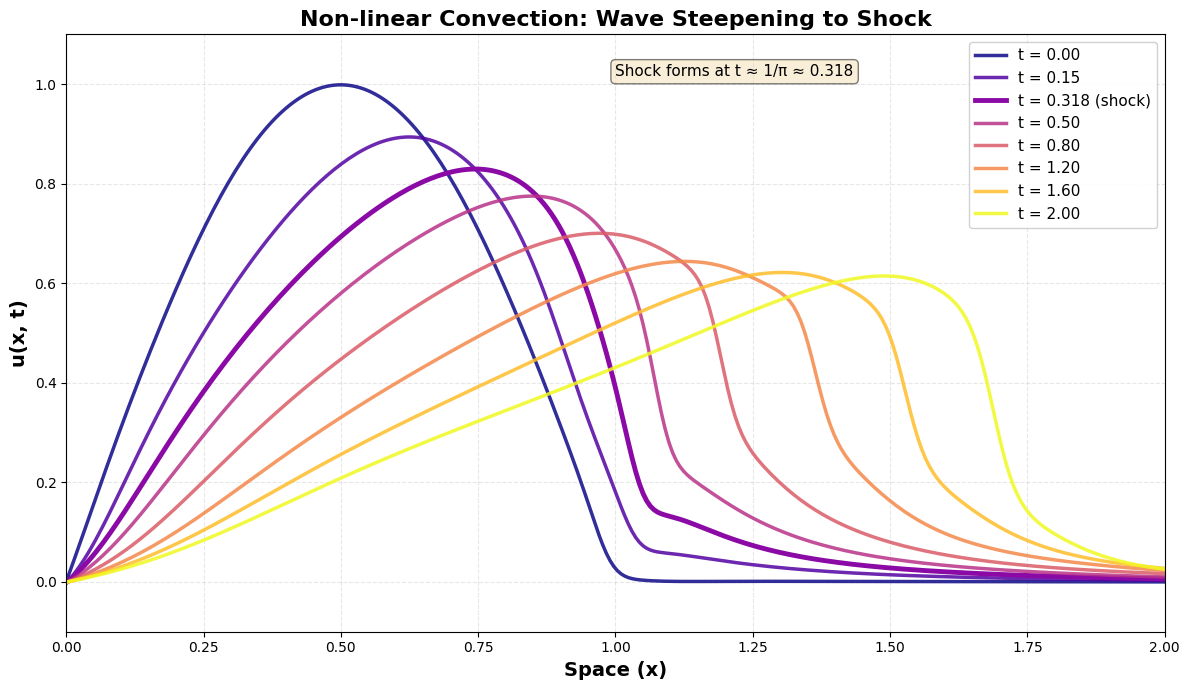

In [32]:
def plot_time_slices_shock():
    """Plot u vs x at key time slices including shock formation"""
    fig, ax = plt.subplots(1, 1, figsize=(12, 7))
    
    # Include shock formation time!
    time_slices = [0.0, 0.15, 0.318, 0.5, 0.8, 1.2, 1.6, 2.0]
    x_vals = jnp.linspace(0, 2, 300)
    
    colors = plt.cm.plasma(jnp.linspace(0, 1, len(time_slices)))
    
    for idx, t_val in enumerate(time_slices):
        t_vals = jnp.full_like(x_vals, t_val)
        tx_input = jnp.stack([t_vals, x_vals], axis=1)
        u_pred = network(params, tx_input).ravel()
        
        # Special label for shock time
        if t_val == 0.318:
            label = f't = {t_val:.3f} (shock)'
            linewidth = 3.5
            alpha = 1.0
        else:
            label = f't = {t_val:.2f}'
            linewidth = 2.5
            alpha = 0.85
        
        ax.plot(x_vals, u_pred, color=colors[idx], linewidth=linewidth, 
                label=label, alpha=alpha)
    
    ax.set_xlabel('Space (x)', fontsize=14, fontweight='bold')
    ax.set_ylabel('u(x, t)', fontsize=14, fontweight='bold')
    ax.set_title('Non-linear Convection: Wave Steepening to Shock', 
                 fontsize=16, fontweight='bold')
    ax.set_xlim(0, 2)
    ax.set_ylim(-0.1, 1.1)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(loc='upper right', fontsize=11, framealpha=0.9)
    
    # Add annotation
    ax.text(0.5, 0.95, 'Shock forms at t ≈ 1/π ≈ 0.318', 
            transform=ax.transAxes, fontsize=11, 
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
            verticalalignment='top')
    
    plt.tight_layout()
    plt.savefig('convection_time_slices.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

plot_time_slices_shock()

### 3D Visualization

In [34]:
from mpl_toolkits.mplot3d import Axes3D
import os

# Create directory
os.makedirs('frames_3d_learning', exist_ok=True)

def plot_3d_learning(params_snapshot, iteration):
    """Plot 3D surface showing learning progress"""
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Create grid (only show x in [0, 2])
    t_vals = jnp.linspace(0, 2, 60)
    x_vals = jnp.linspace(0, 2, 60)
    T_grid, X_grid = jnp.meshgrid(t_vals, x_vals)
    
    # PINN prediction
    TX_flat = jnp.stack([T_grid.ravel(), X_grid.ravel()], axis=1)
    U_pred_flat = network(params_snapshot, TX_flat)
    U_pred = U_pred_flat.reshape(60, 60)
    
    # Plot surface
    surf = ax.plot_surface(T_grid, X_grid, U_pred, cmap='plasma', 
                           alpha=0.95, edgecolor='none',
                           vmin=0, vmax=1.0, antialiased=True,
                           linewidth=0, rcount=60, ccount=60)
    
    # Add shock formation plane
    t_shock = 0.318
    x_shock = jnp.linspace(0, 2, 30)
    z_shock = jnp.linspace(0, 1, 30)
    X_shock, Z_shock = jnp.meshgrid(x_shock, z_shock)
    T_shock = jnp.full_like(X_shock, t_shock)
    ax.plot_surface(T_shock, X_shock, Z_shock, alpha=0.15, color='cyan', 
                   edgecolor='none')
    
    # Better viewing angle to see wave traveling
    ax.view_init(elev=25, azim=225)  # Changed from 135 to 225
    # This angle looks from the "back-left", showing:
    # - Time axis going left-to-right
    # - Space axis going away from you
    # - Wave traveling visible!
    
    ax.set_xlabel('Time (t)', fontsize=12, fontweight='bold', labelpad=10)
    ax.set_ylabel('Space (x)', fontsize=12, fontweight='bold', labelpad=10)
    ax.set_zlabel('u(x, t)', fontsize=12, fontweight='bold', labelpad=10)
    ax.set_title('Non-linear Convection: PINN Learning', 
                 fontsize=15, fontweight='bold', pad=20)
    ax.set_xlim(0, 2)
    ax.set_ylim(0, 2)
    ax.set_zlim(0, 1.1)
    
    # Colorbar
    cbar = fig.colorbar(surf, ax=ax, shrink=0.6, aspect=10, pad=0.1)
    cbar.set_label('u(x, t)', fontsize=11)
    
    # Training iteration text
    ax.text2D(0.02, 0.98, f'Training Step: {iteration}', 
              transform=ax.transAxes, fontsize=13, fontweight='bold',
              verticalalignment='top',
              bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    
    filename = f'frames_3d_learning/frame_{iteration:06d}.png'
    plt.savefig(filename, dpi=100, bbox_inches='tight', facecolor='white')
    plt.close()
    return filename

# Generate frames from snapshots
print("Generating 3D learning frames...")
files_3d = []
for i, (params_snap, iteration) in enumerate(zip(snapshots, snapshot_iterations)):
    filename = plot_3d_learning(params_snap, iteration)
    files_3d.append(filename)
    if (i + 1) % 10 == 0:
        print(f"Generated {i+1}/{len(snapshots)} frames")

print(f"\nTotal 3D frames: {len(files_3d)}")

# Create GIF
from PIL import Image

def save_gif_PIL(outfile, files, fps=10, loop=0):
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], 
                 save_all=True, duration=int(1000/fps), loop=loop)

print("Creating 3D learning GIF...")
save_gif_PIL("convection_3d_learning.gif", files_3d, fps=10, loop=0)
print("Done! Check convection_3d_learning.gif")

Generating 3D learning frames...
Generated 10/133 frames
Generated 20/133 frames
Generated 30/133 frames
Generated 40/133 frames
Generated 50/133 frames
Generated 60/133 frames
Generated 70/133 frames
Generated 80/133 frames
Generated 90/133 frames
Generated 100/133 frames
Generated 110/133 frames
Generated 120/133 frames
Generated 130/133 frames

Total 3D frames: 133
Creating 3D learning GIF...
Done! Check convection_3d_learning.gif


### 3D with Rotation

In [35]:
from mpl_toolkits.mplot3d import Axes3D
import os

# Create directory
os.makedirs('frames_3d_rotating', exist_ok=True)

def plot_3d_rotating(params_snapshot, iteration, frame_index, total_frames):
    """Plot 3D surface with rotating view"""
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Create grid (only show x in [0, 2])
    t_vals = jnp.linspace(0, 2, 60)
    x_vals = jnp.linspace(0, 2, 60)
    T_grid, X_grid = jnp.meshgrid(t_vals, x_vals)
    
    # PINN prediction
    TX_flat = jnp.stack([T_grid.ravel(), X_grid.ravel()], axis=1)
    U_pred_flat = network(params_snapshot, TX_flat)
    U_pred = U_pred_flat.reshape(60, 60)
    
    # Plot surface
    surf = ax.plot_surface(T_grid, X_grid, U_pred, cmap='plasma', 
                           alpha=0.95, edgecolor='none',
                           vmin=0, vmax=1.0, antialiased=True,
                           linewidth=0, rcount=60, ccount=60)
    
    # Add shock formation plane
    t_shock = 0.318
    x_shock = jnp.linspace(0, 2, 30)
    z_shock = jnp.linspace(0, 1, 30)
    X_shock, Z_shock = jnp.meshgrid(x_shock, z_shock)
    T_shock = jnp.full_like(X_shock, t_shock)
    ax.plot_surface(T_shock, X_shock, Z_shock, alpha=0.15, color='cyan', 
                   edgecolor='none')
    
    # ROTATING VIEW: azimuth changes smoothly across frames
    # Complete 360 degree rotation over all frames
    azim = 180 + (frame_index / total_frames) * 360  # Start at 180, rotate full circle
    elev = 25  # Keep elevation constant
    
    ax.view_init(elev=elev, azim=azim)
    
    ax.set_xlabel('Time (t)', fontsize=12, fontweight='bold', labelpad=10)
    ax.set_ylabel('Space (x)', fontsize=12, fontweight='bold', labelpad=10)
    ax.set_zlabel('u(x, t)', fontsize=12, fontweight='bold', labelpad=10)
    ax.set_title('Non-linear Convection: PINN Learning (Rotating View)', 
                 fontsize=15, fontweight='bold', pad=20)
    ax.set_xlim(0, 2)
    ax.set_ylim(0, 2)
    ax.set_zlim(0, 1.1)
    
    # Colorbar
    cbar = fig.colorbar(surf, ax=ax, shrink=0.6, aspect=10, pad=0.1)
    cbar.set_label('u(x, t)', fontsize=11)
    
    # Training iteration and angle info
    ax.text2D(0.02, 0.98, f'Training Step: {iteration}\nAngle: {azim:.0f}°', 
              transform=ax.transAxes, fontsize=12, fontweight='bold',
              verticalalignment='top',
              bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    
    filename = f'frames_3d_rotating/frame_{frame_index:06d}.png'
    plt.savefig(filename, dpi=100, bbox_inches='tight', facecolor='white')
    plt.close()
    return filename

# Generate frames from snapshots with rotation
print("Generating 3D rotating frames...")
files_3d_rot = []
total_frames = len(snapshots)

for i, (params_snap, iteration) in enumerate(zip(snapshots, snapshot_iterations)):
    filename = plot_3d_rotating(params_snap, iteration, i, total_frames)
    files_3d_rot.append(filename)
    if (i + 1) % 10 == 0:
        print(f"Generated {i+1}/{total_frames} frames")

print(f"\nTotal 3D frames: {len(files_3d_rot)}")

# Create GIF
from PIL import Image

def save_gif_PIL(outfile, files, fps=10, loop=0):
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], 
                 save_all=True, duration=int(1000/fps), loop=loop)

print("Creating rotating 3D GIF...")
save_gif_PIL("convection_3d_rotating.gif", files_3d_rot, fps=10, loop=0)
print("Done! Check convection_3d_rotating.gif")

Generating 3D rotating frames...
Generated 10/133 frames
Generated 20/133 frames
Generated 30/133 frames
Generated 40/133 frames
Generated 50/133 frames
Generated 60/133 frames
Generated 70/133 frames
Generated 80/133 frames
Generated 90/133 frames
Generated 100/133 frames
Generated 110/133 frames
Generated 120/133 frames
Generated 130/133 frames

Total 3D frames: 133
Creating rotating 3D GIF...
Done! Check convection_3d_rotating.gif


### 2D Visualization

In [36]:
import matplotlib.pyplot as plt
import os

# Create directory for frames
os.makedirs('frames_timeslices', exist_ok=True)

def plot_timeslices_learning(params_snapshot, iteration):
    """Plot PINN predictions at 4 time slices with adaptive x-ranges"""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    # Time slices and corresponding x-ranges (adjusted to follow the wave)
    time_configs = [
        {'t': 0.0, 'xlim': (0.0, 1.3), 'label': 't = 0.00 (initial)'},
        {'t': 0.318, 'xlim': (0.2, 1.5), 'label': 't = 0.318 (shock)'},
        {'t': 1.0, 'xlim': (0.6, 2.0), 'label': 't = 1.00'},
        {'t': 2.0, 'xlim': (1.0, 2.0), 'label': 't = 2.00'},
    ]
    
    for idx, config in enumerate(time_configs):
        ax = axes[idx]
        t_val = config['t']
        xlim = config['xlim']
        
        # Create x values for this view window
        x_vals = jnp.linspace(xlim[0], xlim[1], 200)
        
        # Initial condition (for reference at t=0)
        if t_val == 0.0:
            u_initial = jnp.where(x_vals <= 1.0, 
                                 jnp.sin(jnp.pi * x_vals), 
                                 0.0)
            ax.plot(x_vals, u_initial, 'k--', linewidth=2, 
                   label='Initial Condition', alpha=0.4)
        
        # PINN prediction
        t_vals = jnp.full_like(x_vals, t_val)
        tx_input = jnp.stack([t_vals, x_vals], axis=1)
        u_pred = network(params_snapshot, tx_input).ravel()
        
        # Plot
        color = 'darkblue' if t_val == 0.0 else 'purple' if t_val == 0.318 else 'crimson' if t_val == 1.0 else 'darkorange'
        ax.plot(x_vals, u_pred, color=color, linewidth=3, 
                label='PINN Prediction')
        
        # Styling
        ax.set_xlabel('Space (x)', fontsize=12, fontweight='bold')
        ax.set_ylabel('u(x, t)', fontsize=12, fontweight='bold')
        ax.set_title(config['label'], fontsize=13, fontweight='bold')
        ax.set_xlim(xlim)
        ax.set_ylim(-0.05, 1.05)
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.legend(loc='upper right', fontsize=10)
        
        # Mark shock formation on that subplot
        if t_val == 0.318:
            ax.text(0.5, 0.95, '⚠ Shock Formation Time', 
                   transform=ax.transAxes, fontsize=11,
                   bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.6),
                   ha='center', va='top')
    
    plt.suptitle(f'Non-linear Convection PINN Learning - Step: {iteration}', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    filename = f'frames_timeslices/frame_{iteration:06d}.png'
    plt.savefig(filename, dpi=100, bbox_inches='tight', facecolor='white')
    plt.close()
    return filename

# Generate frames from snapshots
print("Generating time slice learning frames...")
files_timeslices = []
for i, (params_snap, iteration) in enumerate(zip(snapshots, snapshot_iterations)):
    filename = plot_timeslices_learning(params_snap, iteration)
    files_timeslices.append(filename)
    if (i + 1) % 10 == 0:
        print(f"Generated {i+1}/{len(snapshots)} frames")

print(f"\nTotal frames: {len(files_timeslices)}")

# Create GIF
from PIL import Image

def save_gif_PIL(outfile, files, fps=10, loop=0):
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], 
                 save_all=True, duration=int(1000/fps), loop=loop)

print("Creating time slices learning GIF...")
save_gif_PIL("convection_timeslices_learning.gif", files_timeslices, fps=10, loop=0)
print("Done! Check convection_timeslices_learning.gif")

Generating time slice learning frames...
Generated 10/133 frames
Generated 20/133 frames
Generated 30/133 frames
Generated 40/133 frames
Generated 50/133 frames
Generated 60/133 frames
Generated 70/133 frames
Generated 80/133 frames
Generated 90/133 frames
Generated 100/133 frames
Generated 110/133 frames
Generated 120/133 frames
Generated 130/133 frames

Total frames: 133
Creating time slices learning GIF...
Done! Check convection_timeslices_learning.gif
